[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/MSML_602/blob/main/Project/DL_based_image_classification.ipynb)

# **Relevant Installs**

In [1]:
!pip install "cleanvision[huggingface]"
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

# **Relevant Imports**

In [19]:
# Import PyTorch
import torch
from torch import nn

# import pandas as pd
import os
import pandas as pd
import numpy as np
from datasets import load_dataset, concatenate_datasets
from cleanvision import Imagelab
from PIL import Image
import requests
import cv2
import imagehash

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, TensorDataset

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# **Dataset**

### Downloading Dataset

In [4]:
dataset_dict = load_dataset("zalando-datasets/fashion_mnist")

# train dataset
train_data = dataset_dict['train']
train_images = np.array(train_data['image'])
train_labels = np.array(train_data['label'])

# test dataset
test_data = dataset_dict['test']
test_images = np.array(test_data['image'])
test_labels = np.array(test_data['label'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

### Visualizing Dataset

In [5]:
label_dic = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}

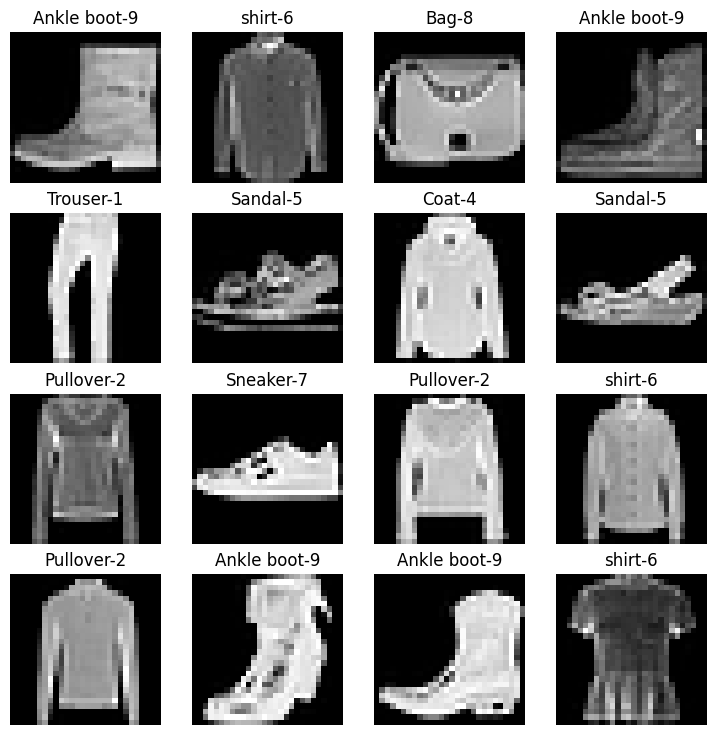

In [6]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))

for i in range(1, 4 * 4 + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img = train_images[random_idx]
    label = train_labels[random_idx]
    fig.add_subplot(4, 4, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f'{label_dic[label]}-{label}')
    plt.axis(False);

### Data Cleaning

In [7]:
def data_cleaner(ims):

    imagelab = Imagelab(hf_dataset=ims, image_key="image")
    imagelab.find_issues()
    issue_df = imagelab.issues
    print(issue_df.columns)

    # handling images with low information
    images_with_low_information = issue_df[issue_df['is_low_information_issue'] == True].reset_index()[['index','low_information_score']]
    img_index_with_low_information = images_with_low_information['index']


    # handling dark images
    dark_images = issue_df[issue_df['is_dark_issue'] == True].reset_index()[['index','dark_score']]
    dark_img_index = dark_images['index']


    # handling duplicate images
    duplicate_images = issue_df[issue_df['is_near_duplicates_issue'] == True].reset_index()[['index','near_duplicates_score']]
    duplicate_images_index = []
    for i in imagelab.info["near_duplicates"]["sets"]:
      for j,counter in zip(i,range(0,len(i))):

          if counter == 0:
            continue

          else:
            duplicate_images_index.append(j)

    # appending all the images to be removed from dataset
    img_index_to_remove = list(set(list(img_index_with_low_information) + list(dark_img_index) + list(duplicate_images_index)))

    return img_index_to_remove

In [8]:
to_remove = data_cleaner(train_data)

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

Issue checks completed. 70003 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Index(['odd_size_score', 'is_odd_size_issue', 'odd_aspect_ratio_score',
       'is_odd_aspect_ratio_issue', 'low_information_score',
       'is_low_information_issue', 'light_score', 'is_light_issue',
       'grayscale_score', 'is_grayscale_issue', 'dark_score', 'is_dark_issue',
       'blurry_score', 'is_blurry_issue', 'exact_duplicates_score',
       'is_exact_duplicates_issue', 'near_duplicates_score',
       'is_near_duplicates_issue'],
      dtype='object')


In [9]:
print(f'Number of bad images found : {len(to_remove)}')
print(f'Following are the image indexes that needs to be removed from the dataset : {to_remove}')

Number of bad images found : 9497
Following are the image indexes that needs to be removed from the dataset : [8, 13, 14, 32785, 32786, 32793, 30, 38, 43, 32811, 32815, 32820, 32825, 59, 32827, 32828, 62, 63, 32835, 69, 78, 32848, 82, 32850, 87, 32855, 32858, 91, 32859, 32862, 32863, 97, 32867, 102, 103, 32875, 32877, 32885, 119, 120, 131, 133, 32904, 138, 32910, 145, 146, 32916, 32921, 155, 163, 32932, 173, 32948, 189, 192, 32966, 201, 32972, 209, 210, 32978, 217, 32985, 32988, 32996, 230, 33008, 33012, 247, 33017, 250, 33022, 257, 259, 33027, 33042, 277, 278, 279, 33053, 33055, 288, 33059, 33060, 33061, 33063, 300, 33069, 305, 308, 33077, 310, 317, 33086, 319, 320, 330, 33102, 33103, 33107, 340, 341, 343, 33116, 349, 33124, 357, 360, 363, 365, 33134, 33136, 369, 370, 379, 382, 33150, 384, 33154, 33156, 389, 393, 33162, 33166, 403, 33175, 414, 33182, 417, 418, 33186, 33190, 423, 33191, 427, 33199, 432, 435, 33207, 33215, 453, 456, 33229, 33231, 467, 469, 33238, 475, 478, 33249, 482, 3

In [10]:
# new image list
reduced_train_images = []
reduced_train_labels = []

for counter, im, label in zip(range(len(train_images)), train_images, train_labels):

    if counter in to_remove:
        continue

    else:
        reduced_train_images.append(im)
        reduced_train_labels.append(label)

### Creating Dataloaders

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize for grayscale images
])

In [20]:
reduced_train_images_tensor = torch.stack([transform(Image.fromarray(img)) for img in reduced_train_images])
reduced_train_labels_tensor = torch.tensor(np.array(reduced_train_labels), dtype=torch.long)
train_dataset = TensorDataset(reduced_train_images_tensor, reduced_train_labels_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_features_batch, train_labels_batch = next(iter(train_dataloader))

print(f"Features Batch Size {train_features_batch.shape}")
print(f"Labels Batch Size {train_labels_batch.shape}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of 32")

Features Batch Size torch.Size([32, 1, 28, 28])
Labels Batch Size torch.Size([32])
Length of train dataloader: 1579 batches of 32


In [21]:
reduced_test_images_tensor = torch.stack([transform(Image.fromarray(img)) for img in test_images])
reduced_test_labels_tensor = torch.tensor(np.array(test_labels), dtype=torch.long)
test_dataset = TensorDataset(reduced_test_images_tensor, reduced_test_labels_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_features_batch, test_labels_batch = next(iter(test_dataloader))

print(f"Features Batch Size {test_features_batch.shape}")
print(f"Labels Batch Size {test_labels_batch.shape}")
print(f"Length of train dataloader: {len(test_dataloader)} batches of 32")

Features Batch Size torch.Size([32, 1, 28, 28])
Labels Batch Size torch.Size([32])
Length of train dataloader: 313 batches of 32


# **Modelling and Training FFNN**

In [28]:
import torch
from torch import nn

class FFNN_Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=392),nn.ReLU(),
            nn.Linear(in_features=392, out_features=196),nn.ReLU(),
            nn.Linear(in_features=196, out_features=98),nn.ReLU(),
            nn.Linear(in_features=98, out_features=49),nn.ReLU(),
            nn.Linear(in_features=49, out_features=20),nn.ReLU(),
            nn.Linear(in_features=20, out_features=10),nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [29]:
torch.manual_seed(42)
model = FFNN_Model().to(device)

In [30]:
next(model.parameters()).device # check model device

device(type='cuda', index=0)

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

In [32]:
def accuracy_fn(y_true, y_pred):
    return (torch.eq(y_true, y_pred).sum().item() / len(y_pred)) * 100


In [34]:
torch.manual_seed(42)
for epoch in tqdm(range(50)): # running for 3 epochs

    print(f"Epoch: {epoch}\n-------")

    '''
    TRAINING
    '''
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X) #Forward pass

        loss = loss_fn(y_pred, y) # Calculate loss (per batch)
        acc = accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))

        train_loss += loss # accumulatively add up the loss per epoch
        train_acc += acc # Go from logits -> pred labels

        optimizer.zero_grad() # Optimizer zero grad
        loss.backward() # Loss backward
        optimizer.step() # Optimizer step

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    '''
    TESTING
    '''
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X) # Forward pass

            loss = loss_fn(test_pred, y)
            acc = accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))

            test_loss += loss
            test_acc += acc

        # Calculations on test metrics need to happen inside torch.inference_mode()
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Test loss: {test_loss:.5f}  | Test acc: {test_acc:.2f}%\n")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 0.65714 | Train accuracy: 74.94%
Test loss: 0.83134  | Test acc: 67.26%

Epoch: 1
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 0.63179 | Train accuracy: 75.65%
Test loss: 0.86030  | Test acc: 67.67%

Epoch: 2
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 0.61356 | Train accuracy: 76.05%
Test loss: 1.05117  | Test acc: 64.28%

Epoch: 3
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 samples
Train loss: 0.60116 | Train accuracy: 76.56%
Test loss: 0.80006  | Test acc: 68.79%

Epoch: 4
-------
Looked at 0/50503 samples
Looked at 12800/50503 samples
Looked at 25600/50503 samples
Looked at 38400/50503 sam

# **Modelling and Training ResNet**

# **Modelling and Training Vision Transformers**